Double-Moon Classification Experiment

Running experiment with d = 1
Generated 1000 training samples and 2000 test samples
Converged at epoch 3


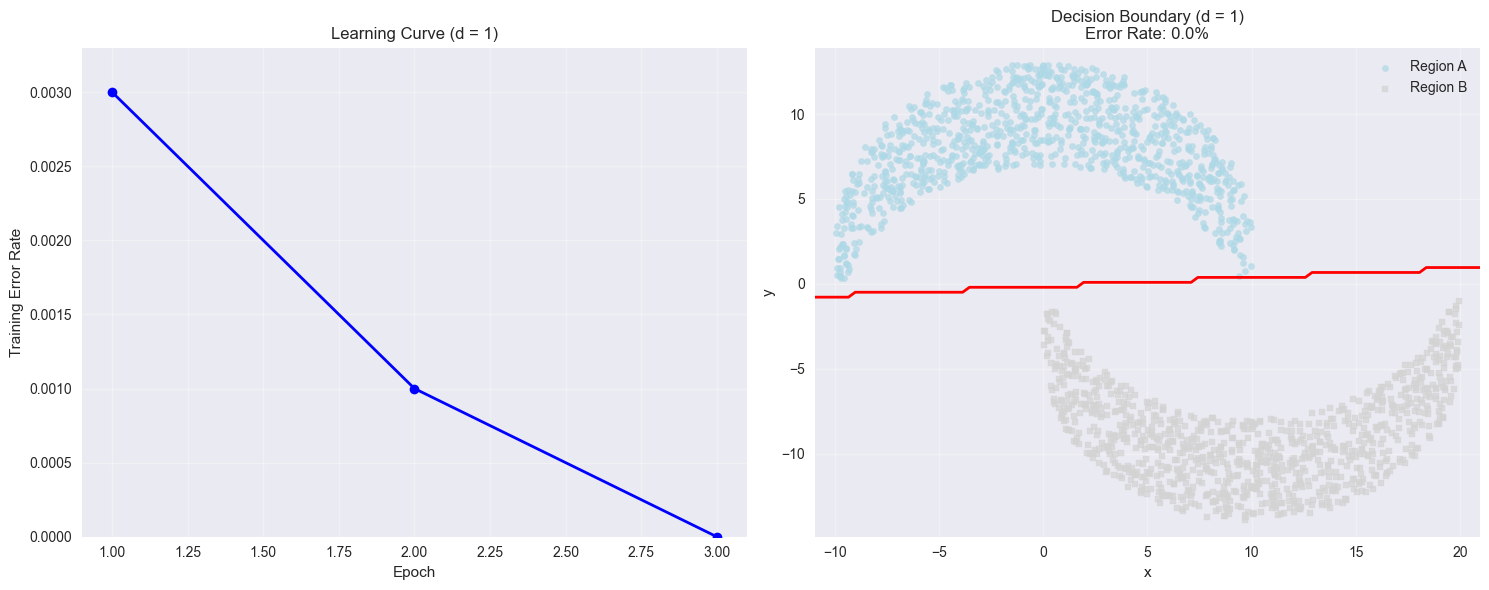

Final accuracy: 1.000
Final training error: 0.000

Running experiment with d = -4
Generated 1000 training samples and 2000 test samples


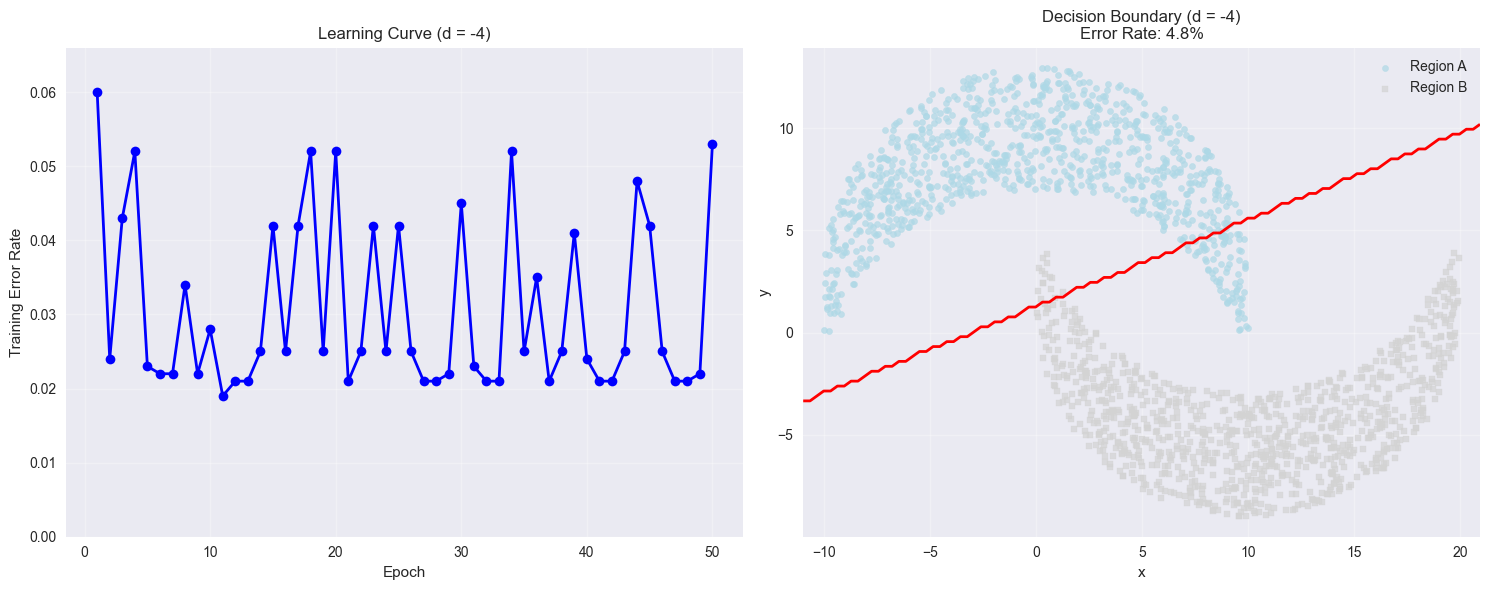

Final accuracy: 0.952
Final training error: 0.053

EXPERIMENT SUMMARY

d = 1 (Linearly Separable):
  Accuracy: 100.0%
  Error Rate: 0.0%
  Epochs: 3

d = -4 (Non-linearly Separable):
  Accuracy: 95.2%
  Error Rate: 4.8%
  Epochs: 50


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
import seaborn as sns

class DoubleMoonExperiment:
    def __init__(self, r=10, w=6, d=1):
        """
        Initialize the double-moon classification problem

        Parameters:
        r: radius of each moon (default: 10)
        w: width of each moon (default: 6)
        d: vertical separation distance (default: 1)
        """
        self.r = r
        self.w = w
        self.d = d

    def generate_moon_points(self, n_points, region='A'):
        """Generate random points within a moon region"""
        points = []

        while len(points) < n_points:
            if region == 'A':
                # Region A: centered at origin, upper half
                x = np.random.uniform(-self.r, self.r)
                y_center = np.sqrt(self.r**2 - x**2)
                y = np.random.uniform(y_center - self.w/2, y_center + self.w/2)

                # Only keep points in upper half and within moon width
                if y >= 0 and y <= y_center + self.w/2:
                    points.append([x, y])

            else:  # Region B
                # Region B: offset by r in x, displaced by d in y, lower half
                x = np.random.uniform(0, 2*self.r)
                y_center = -np.sqrt(self.r**2 - (x - self.r)**2) - self.d
                y = np.random.uniform(y_center - self.w/2, y_center + self.w/2)

                # Only keep points in lower half and within moon width
                if y <= 0 - self.d and y >= y_center - self.w/2:
                    points.append([x, y])

        return np.array(points)

    def generate_dataset(self, n_train=1000, n_test=2000):
        """Generate training and test datasets"""
        # Training data
        train_A = self.generate_moon_points(n_train//2, 'A')
        train_B = self.generate_moon_points(n_train//2, 'B')

        X_train = np.vstack([train_A, train_B])
        y_train = np.hstack([np.ones(len(train_A)), np.zeros(len(train_B))])

        # Test data
        test_A = self.generate_moon_points(n_test//2, 'A')
        test_B = self.generate_moon_points(n_test//2, 'B')

        X_test = np.vstack([test_A, test_B])
        y_test = np.hstack([np.ones(len(test_A)), np.zeros(len(test_B))])

        # Shuffle the data
        train_idx = np.random.permutation(len(X_train))
        test_idx = np.random.permutation(len(X_test))

        return (X_train[train_idx], y_train[train_idx],
                X_test[test_idx], y_test[test_idx])

    def train_perceptron(self, X_train, y_train, max_iter=1000, learning_rate=0.1):
        """Train perceptron and track learning curve"""
        perceptron = Perceptron(max_iter=max_iter, eta0=learning_rate,
                              random_state=42, shuffle=True)

        # Track learning curve by training epoch by epoch
        errors = []
        n_epochs = min(50, max_iter)  # Limit to 50 epochs for visualization

        for epoch in range(n_epochs):
            # Partial fit for one epoch
            perceptron.partial_fit(X_train, y_train, classes=[0, 1])

            # Calculate training error
            y_pred = perceptron.predict(X_train)
            error = np.mean(y_pred != y_train)
            errors.append(error)

            # Early stopping if converged
            if error == 0:
                print(f"Converged at epoch {epoch + 1}")
                break

        return perceptron, errors

    def plot_results(self, X_train, y_train, X_test, y_test, perceptron, errors):
        """Plot learning curve and decision boundary"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Plot 1: Learning Curve
        ax1.plot(range(1, len(errors) + 1), errors, 'b-', linewidth=2, marker='o')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Training Error Rate')
        ax1.set_title(f'Learning Curve (d = {self.d})')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, max(errors) * 1.1)

        # Plot 2: Decision Boundary and Test Points
        # Create mesh for decision boundary
        x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
        y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                           np.linspace(y_min, y_max, 100))

        # Predict on mesh
        mesh_points = np.column_stack([xx.ravel(), yy.ravel()])
        Z = perceptron.predict(mesh_points)
        Z = Z.reshape(xx.shape)

        # Plot decision boundary
        ax2.contour(xx, yy, Z, levels=[0.5], colors='red', linewidths=2)

        # Plot test points
        region_A_mask = y_test == 1
        region_B_mask = y_test == 0

        ax2.scatter(X_test[region_A_mask, 0], X_test[region_A_mask, 1],
                   c='lightblue', marker='o', s=20, alpha=0.7, label='Region A')
        ax2.scatter(X_test[region_B_mask, 0], X_test[region_B_mask, 1],
                   c='lightgray', marker='s', s=20, alpha=0.7, label='Region B')

        # Calculate and display accuracy
        y_pred = perceptron.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        error_rate = (1 - accuracy) * 100

        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.set_title(f'Decision Boundary (d = {self.d})\nError Rate: {error_rate:.1f}%')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return accuracy

def run_experiment(d_values=[1, -4]):
    """Run the complete double-moon experiment"""
    results = {}

    for d in d_values:
        print(f"\n{'='*50}")
        print(f"Running experiment with d = {d}")
        print(f"{'='*50}")

        # Initialize experiment
        experiment = DoubleMoonExperiment(d=d)

        # Generate data
        X_train, y_train, X_test, y_test = experiment.generate_dataset()
        print(f"Generated {len(X_train)} training samples and {len(X_test)} test samples")

        # Train perceptron
        perceptron, errors = experiment.train_perceptron(X_train, y_train)

        # Plot results
        accuracy = experiment.plot_results(X_train, y_train, X_test, y_test,
                                         perceptron, errors)

        results[d] = {
            'accuracy': accuracy,
            'final_error': errors[-1],
            'epochs_to_converge': len(errors)
        }

        print(f"Final accuracy: {accuracy:.3f}")
        print(f"Final training error: {errors[-1]:.3f}")

    return results

# Run the experiment
if __name__ == "__main__":
    print("Double-Moon Classification Experiment")
    print("=====================================")
    # Set style
    plt.style.use('seaborn-v0_8')

    # Run experiments
    results = run_experiment([1, -4])

    # Print summary
    print(f"\n{'='*50}")
    print("EXPERIMENT SUMMARY")
    print(f"{'='*50}")

    for d, result in results.items():
        separability = "Linearly Separable" if d > 0 else "Non-linearly Separable"
        print(f"\nd = {d} ({separability}):")
        print(f"  Accuracy: {result['accuracy']:.1%}")
        print(f"  Error Rate: {(1-result['accuracy'])*100:.1f}%")
        print(f"  Epochs: {result['epochs_to_converge']}")
